# Deep Neural Networks: Comprehensive Guide

In [54]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset

# Set random seed for reproducibility
torch.manual_seed(42)

# GPU/CPU device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create a simple deep network with dropout
class SimpleDeepNet(nn.Module):
    def __init__(self, dropout_prob=0.0):
        super(SimpleDeepNet, self).__init__()
        
        # Network layers
        self.layer1 = nn.Linear(2, 100)
        self.layer2 = nn.Linear(100, 100) 
        self.layer3 = nn.Linear(100, 1)
        
        # Dropout layer - will be applied after ReLU activations
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        # First hidden layer with ReLU and dropout
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)  # Apply dropout after activation
        
        # Second hidden layer with ReLU and dropout
        x = torch.relu(self.layer2(x))
        x = self.dropout(x)  # Apply dropout after activation
        
        # Output layer (no activation for regression)
        x = self.layer3(x)
        return x

Using device: cuda


In [55]:
# Create synthetic dataset
class SyntheticDataset(Dataset):
    def __init__(self, n_samples=1000, noise=0.1):
        # Generate inputs between -1 and 1
        self.x = torch.rand(n_samples, 2) * 2 - 1
        
        # Generate targets with nonlinear function and noise
        self.y = 0.5 * self.x[:, 0]**2 + 0.3 * self.x[:, 1]**3 + 0.1 * self.x[:, 0] * self.x[:, 1]
        self.y = self.y.unsqueeze(1) + noise * torch.randn(n_samples, 1)
        
    def __len__(self):
        return len(self.x)
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Create training and validation datasets
train_data = SyntheticDataset(n_samples=500, noise=0.2)
val_data = SyntheticDataset(n_samples=200, noise=0.2)

In [59]:
# Train models with and without dropout
def train_model(model, train_data, val_data, epochs=300, lr=0.01):
    # Initialize optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # Track losses
    train_losses = []
    val_losses = []
    
    # Training loop
    for epoch in range(epochs):
        # Training
        model.train()  # Set model to training mode (important for dropout)
        optimizer.zero_grad()
        
        # Forward pass on all training data
        outputs = model(train_data.x)
        loss = criterion(outputs, train_data.y)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Record training loss
        train_losses.append(loss.item())
        
        # Validation
        model.eval()  # Set model to evaluation mode (disables dropout)
        with torch.no_grad():
            val_outputs = model(val_data.x)
            val_loss = criterion(val_outputs, val_data.y)
            val_losses.append(val_loss.item())
        
        # Print progress every 50 epochs
        if (epoch + 1) % 50 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
    
    return train_losses, val_losses

In [60]:
# Create models with and without dropout
model_no_dropout = SimpleDeepNet(dropout_prob=0.0).to(device)
model_dropout = SimpleDeepNet(dropout_prob=0.3).to(device)

# Move data to device
train_data.x = train_data.x.to(device)
train_data.y = train_data.y.to(device)
val_data.x = val_data.x.to(device)
val_data.y = val_data.y.to(device)

# Train both models
print("Training model without dropout:")
train_losses_no_dropout, val_losses_no_dropout = train_model(model_no_dropout, train_data, val_data)

print("\nTraining model with dropout:")
train_losses_dropout, val_losses_dropout = train_model(model_dropout, train_data, val_data)

Training model without dropout:
Epoch 50/300, Train Loss: 0.0402, Val Loss: 0.0497
Epoch 100/300, Train Loss: 0.0370, Val Loss: 0.0510
Epoch 150/300, Train Loss: 0.0357, Val Loss: 0.0517
Epoch 200/300, Train Loss: 0.0349, Val Loss: 0.0515
Epoch 250/300, Train Loss: 0.0340, Val Loss: 0.0518
Epoch 300/300, Train Loss: 0.0332, Val Loss: 0.0521

Training model with dropout:
Epoch 50/300, Train Loss: 0.0498, Val Loss: 0.0540
Epoch 100/300, Train Loss: 0.0427, Val Loss: 0.0505
Epoch 150/300, Train Loss: 0.0457, Val Loss: 0.0502
Epoch 200/300, Train Loss: 0.0429, Val Loss: 0.0508
Epoch 250/300, Train Loss: 0.0427, Val Loss: 0.0508
Epoch 300/300, Train Loss: 0.0425, Val Loss: 0.0505


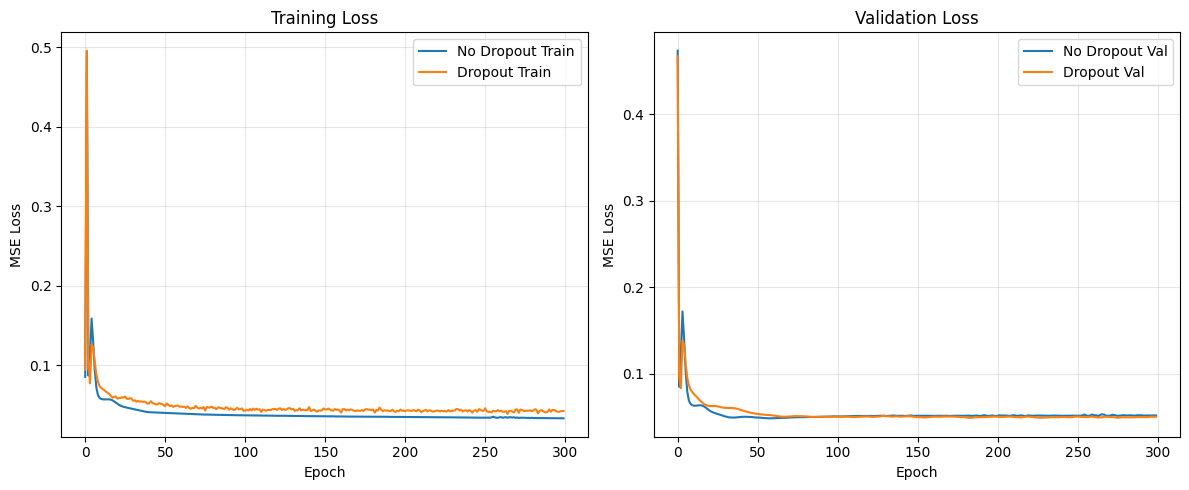


Final losses:
No Dropout - Train: 0.0332, Val: 0.0521
Dropout    - Train: 0.0425, Val: 0.0505

Overfitting measure (val_loss - train_loss):
No Dropout: 0.0189
Dropout:    0.0080


In [61]:
# Visualize results
plt.figure(figsize=(12, 5))

# Plot training losses
plt.subplot(1, 2, 1)
plt.plot(train_losses_no_dropout, label='No Dropout Train')
plt.plot(train_losses_dropout, label='Dropout Train')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot validation losses
plt.subplot(1, 2, 2)
plt.plot(val_losses_no_dropout, label='No Dropout Val')
plt.plot(val_losses_dropout, label='Dropout Val')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show final results
print(f"\nFinal losses:")
print(f"No Dropout - Train: {train_losses_no_dropout[-1]:.4f}, Val: {val_losses_no_dropout[-1]:.4f}")
print(f"Dropout    - Train: {train_losses_dropout[-1]:.4f}, Val: {val_losses_dropout[-1]:.4f}")

# Calculate overfitting measure (difference between train and val loss)
overfit_no_dropout = val_losses_no_dropout[-1] - train_losses_no_dropout[-1]
overfit_dropout = val_losses_dropout[-1] - train_losses_dropout[-1]

print(f"\nOverfitting measure (val_loss - train_loss):")
print(f"No Dropout: {overfit_no_dropout:.4f}")
print(f"Dropout:    {overfit_dropout:.4f}")